### Feature Extraction

* The routines below read the music files, develop the features, and store them away in a parquet file for later processing.
* Where features are vectors, we are capturing only the max, min, mean, standard deviation, kurtosis and skew of those vectors, rather than the full vectors themselves.
* There is a separate notebook for each of the six genres I'm evaluating.
* The first genre notebook (blues) also includes some visualizations and additional explanations of the techniques.


In [1]:
import os, warnings, csv
import IPython.display as ipd
from glob import glob

import librosa, librosa.display

import numpy as np, pandas as pd
from scipy.stats import kurtosis, skew

import matplotlib.pyplot as plt
%matplotlib inline
import hvplot.pandas


In [3]:
# Functions to help with extraction

# Get various moments from the vectors
def get_moments(descriptors):
    result = {}
    for k, v in descriptors.items():
        result['{}_max'.format(k)] = np.max(v)
        result['{}_min'.format(k)] = np.min(v)
        result['{}_mean'.format(k)] = np.mean(v)
        result['{}_std'.format(k)] = np.std(v)
        result['{}_kurtosis'.format(k)] = kurtosis(v)
        result['{}_skew'.format(k)] = skew(v)
    return result

# Collect features from a waveform
def get_features(wave, sr):  
    
# Start with only vector features for which we need moments    
    features = {
                'centroid': None,                      
                'rolloff': None, 
                'flux': None, 
                'rmse': None,
                'zcr': None, 
                'contrast': None, 
                'bandwidth': None, 
                'flatness': None, 
                'chroma_stft': None
               }

# Built-in librosa functions
    features['centroid'] = librosa.feature.spectral_centroid(wave, sr=sr).ravel()
    features['rolloff'] = librosa.feature.spectral_rolloff(wave, sr=sr,).ravel()
    features['flux'] = librosa.onset.onset_strength(y=wave, sr=sr).ravel()
    features['rmse'] = librosa.feature.rms(wave).ravel()
    features['zcr'] = librosa.feature.zero_crossing_rate(wave).ravel()
    features['contrast'] = librosa.feature.spectral_contrast(wave, sr=sr).ravel()
    features['bandwidth'] = librosa.feature.spectral_bandwidth(wave, sr=sr).ravel()
    features['flatness'] = librosa.feature.spectral_flatness(wave).ravel()
    features['chroma_stft']=librosa.feature.chroma_stft(y=wave, sr=sr).ravel()
    
# Special MFCC treatment (13 vectors)
    mfcc = librosa.feature.mfcc(wave, sr=sr, n_mfcc=13)
    for idx, v_mfcc in enumerate(mfcc):
        features['mfcc_{}'.format(idx)] = v_mfcc.ravel()
   
    dict_agg_features = get_moments(features)
    
# Now add final 3 non-vector features
    dict_agg_features['total_frames'] = len(wave)
    
    audible, _ = librosa.effects.trim(wave)
    dict_agg_features['silent_frames'] = len(wave) - len(audible)  
    
    dict_agg_features['tempo'] = librosa.beat.beat_track(wave, sr=sr)[0]   # Estimated beats per minute
    
    return dict_agg_features

In [4]:
# FOR TESTING ONLY
# Process single file and tuck features into file

# Shortest song I could find
audio_file = "/home/stu/final_capstone/music_library/17_Her Majesty.mp3"   

# Sound check for fun
ipd.Audio(audio_file)                                                      

# Drop all features into big array
feature_repo = []                                                          

# Avoid warning about reading MP3s
with warnings.catch_warnings():                                            
    warnings.simplefilter("ignore")
    sound, sr = librosa.load(audio_file)

# Get some simple stats
track_minutes = (len(sound) / sr ) // 60
track_seconds = 60 * ((len(sound) / sr) / 60 - track_minutes)
tempo, beat_frames = librosa.beat.beat_track(y=sound, sr=sr)
print('Sampling Rate:     {:,.0f} times per second'.format(sr))
print('Number of Samples: {:,.0f}'.format(len(sound)))
print('Track length:      {:.0f} minutes {:.0f} seconds'.format(track_minutes, track_seconds))
print('Estimated tempo:   {:.0f} beats per minute'.format(tempo))    

# Get the complex stats
features = get_features(sound,sr)

# Include filename for reference
features["filename"] = audio_file                                

# Collect each set of features
feature_repo.append(features)                                     

# Write out to file
pd.DataFrame(feature_repo).to_parquet('/home/stu/final_capstone/features_test/single.parq', index=False)       
print('single.parq is ready.')

# If desired, listen to the track
ipd.Audio(audio_file)

Sampling Rate:     22,050 times per second
Number of Samples: 573,006
Track length:      0 minutes 26 seconds
Estimated tempo:   99 beats per minute
single.parq is ready.


Examine a few of the results obtained from the `librosa` library.

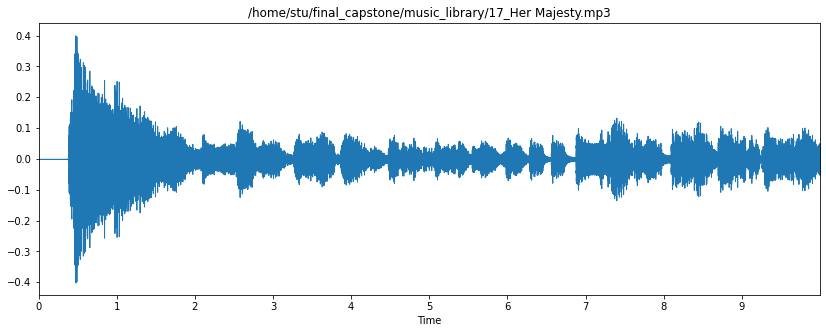

In [6]:
# Just display the waveform itself (first 10 seconds)

plt.figure(figsize=(14, 5))
plt.title(audio_file)
librosa.display.waveplot(sound[0:(10*sr)], sr=sr)

Average Zero Crossings Per Second:  1,227


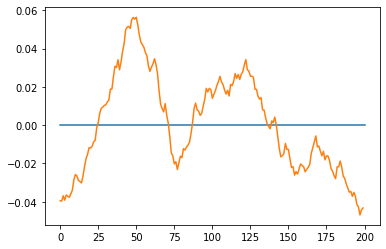

In [5]:
# Illustrate the zero crossing rate
plt.plot([0,200],[0,0])
start_point = len(sound) // 2
plt.plot(sound[start_point:start_point + 200]) # Grab a 200-sample chunk from the middle

# Examine zero_crossings per second
zero_crossings = librosa.zero_crossings(sound, pad=False)  # fills array with true/false if crossing/not crossing
zcps = sum(zero_crossings) / (len(sound) / sr)
print("Average Zero Crossings Per Second:  {:,.0f}".format(zcps))

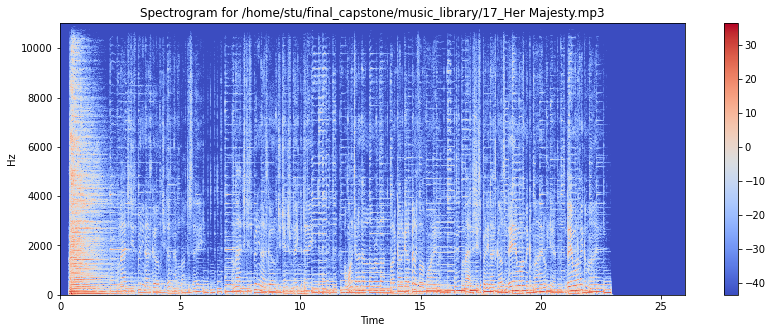

In [6]:
# Look at a spectrogram of the waveform

X = librosa.stft(sound)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz') 
plt.title('Spectrogram for '+audio_file)
plt.colorbar()

In [ ]:
# Analyze the whole genre now

feature_repo = []                                                 # Drop all features into big array

files = glob('/home/stu/final_capstone/music_library/blues/**/*.mp3', recursive=True)

files = files[:200]                                                # Keep number manageable for ancient hardware

for file in files:

    with warnings.catch_warnings():                               # Avoid warning about reading MP3s
        warnings.simplefilter("ignore")
        sound, sr = librosa.load(file)

    print('Processing:', file,'...', end = '')

    features = get_features(sound,sr)
    features["filename"] = file                                   # Include filename for reference
    features["genre"] = 'blues'                                   # ***change for each separate routine***

    feature_repo.append(features)                                 # Add to the array
    print("Done.")

pd.DataFrame(feature_repo).to_parquet('/home/stu/final_capstone/features/blues.parq')               # Write out to file            
print('blues.parq is now ready.')

In [ ]:
# Make sure it can be read back in

foo = pd.read_parquet('/home/stu/final_capstone/features/blues.parq')
display(foo.info)
foo.hvplot.table(columns=['filename', 'genre'])